# Machine Learning
***
By: Michael Gleason

This portion of the project takes the data after Collection and EDA and feeds it into 6 different machine learning models:

- `DummyClassifier` - Sanity Check
- `LogisticRegression`
- `DecisionTreeClassifier`
- `LightGBMClassifier`
- `CatBoostClassifier`
- `RandomForestClassifier`

Each model has various strengths and weakness, to ensure that no metric is valued over the other, models have been trained on both F1 Score and ROC AUC score and then evaluated in the same manner for the other metric.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
data = pd.read_csv('spotify_data_more.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          9000 non-null   object 
 1   genre             9000 non-null   object 
 2   danceability      9000 non-null   float64
 3   energy            9000 non-null   float64
 4   key               9000 non-null   int64  
 5   loudness          9000 non-null   float64
 6   mode              9000 non-null   int64  
 7   speechiness       9000 non-null   float64
 8   acousticness      9000 non-null   float64
 9   instrumentalness  9000 non-null   float64
 10  liveness          9000 non-null   float64
 11  valence           9000 non-null   float64
 12  tempo             9000 non-null   float64
 13  type              9000 non-null   object 
 14  uri               9000 non-null   object 
 15  track_href        9000 non-null   object 
 16  analysis_url      9000 non-null   object 


In [3]:
data = data.drop(['track_id', 'type', 'uri', 'track_href', 'analysis_url'], axis=1)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             9000 non-null   object 
 1   danceability      9000 non-null   float64
 2   energy            9000 non-null   float64
 3   key               9000 non-null   int64  
 4   loudness          9000 non-null   float64
 5   mode              9000 non-null   int64  
 6   speechiness       9000 non-null   float64
 7   acousticness      9000 non-null   float64
 8   instrumentalness  9000 non-null   float64
 9   liveness          9000 non-null   float64
 10  valence           9000 non-null   float64
 11  tempo             9000 non-null   float64
 12  duration_ms       9000 non-null   int64  
 13  time_signature    9000 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 984.5+ KB


,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,rock,0.396,0.293,2,-14.062,1,0.0275,0.9410,0.000196,0.1050,0.343,100.307,182360,3
1,rock,0.737,0.495,1,-13.489,1,0.0270,0.0588,0.000009,0.0542,0.967,104.409,197147,4
2,rock,0.534,0.803,10,-9.129,1,0.0743,0.7410,0.000061,0.3070,0.969,167.983,161560,4
3,rock,0.619,0.603,9,-9.481,1,0.0342,0.7120,0.000000,0.0721,0.958,127.433,178933,4
4,rock,0.584,0.367,6,-9.638,0,0.0328,0.5500,0.000014,0.0818,0.588,120.175,176293,4


### Data Scaling

In [4]:
scaler = StandardScaler()
scaled_data = data.drop('genre', axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), index=scaled_data.index, columns=scaled_data.columns)
data[scaled_data.columns] = scaled_data[scaled_data.columns]
data.head()

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,rock,-0.868502,-0.909444,-0.919159,-0.472957,0.766721,-0.645573,1.465086,-0.634026,-0.506656,-0.577294,-0.566898,-0.422265,-1.793574
1,rock,0.927162,-0.197657,-1.201929,-0.394102,0.766721,-0.650648,-0.890971,-0.634542,-0.841004,1.785848,-0.435086,-0.279137,0.243035
2,rock,-0.141811,0.887642,1.343000,0.205913,0.766721,-0.170486,0.930954,-0.634400,0.822839,1.793423,1.607766,-0.623595,0.243035
3,rock,0.305789,0.182903,1.060230,0.157472,0.766721,-0.577558,0.853504,-0.634567,-0.723192,1.751765,0.304755,-0.455436,0.243035
4,rock,0.121483,-0.648690,0.211920,0.135866,-1.304255,-0.591770,0.420857,-0.634529,-0.659350,0.350542,0.071530,-0.480990,0.243035


## Model Training

Test size of 0.1 allows for proper cross validation.

In [5]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print(train.shape)
print(test.shape)

X_train = train.drop(['genre'], axis=1)
y_train = train['genre']
X_test = test.drop(['genre'], axis=1)
y_test = test['genre']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8100, 14)
(900, 14)
(8100, 13) (8100,)
(900, 13) (900,)


In [6]:
# Initializing KFold Instance
cross_validator = KFold(n_splits=3, shuffle=True, random_state=42)

### Dummy Model - Sanity

The dummy model serves as the Sanity test for the purposes of this project.

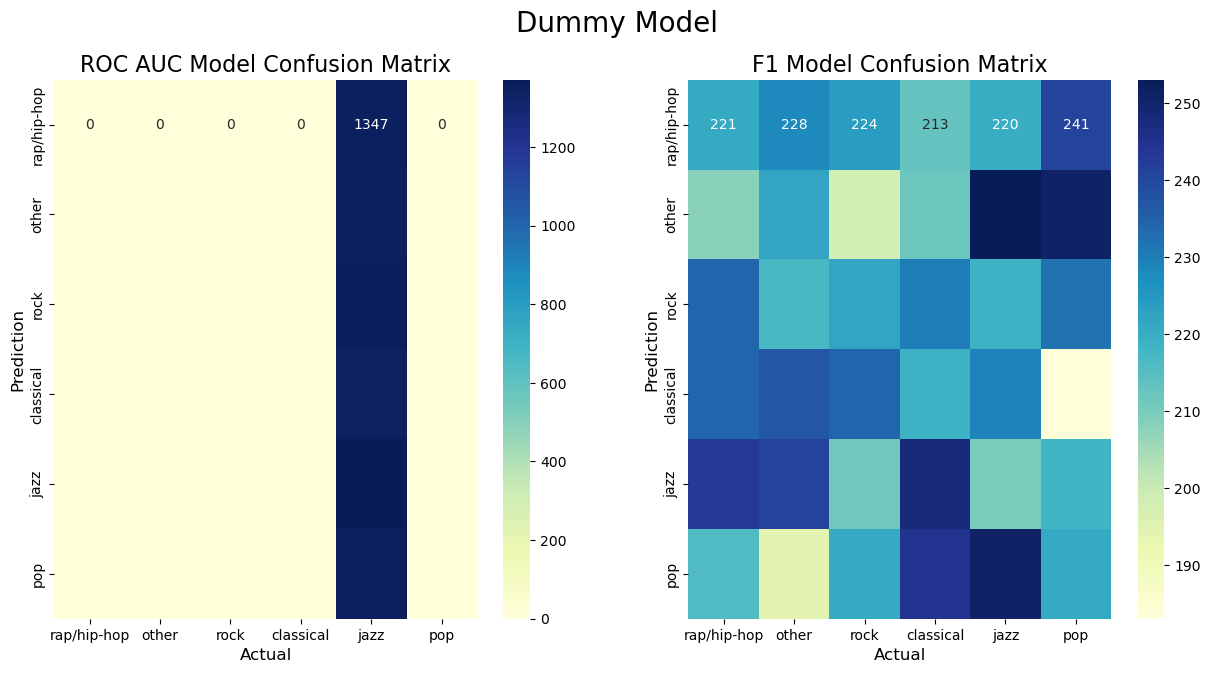

DummyClassifier(constant='rock', random_state=42, strategy='most_frequent') 
 ROC_AUC: 0.5
F1 of ROC_AUC model:  0.04257496923701276 

DummyClassifier(constant='rock', random_state=42, strategy='uniform') 
 F1: 0.1676583761097187
ROC_AUC of F1 model:  0.5


In [7]:
# Creating Dummy model param grid
dummy_params = {
    'strategy':['most_frequent', 'prior', 'stratified', 'uniform', 'constant'],
    'constant':['rock']
}

# Initializing DummyClassifier and its GridSearchCV
dummy_model = DummyClassifier(random_state=42)
dummy_grid_roc_auc = GridSearchCV(dummy_model, dummy_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
dummy_grid_f1 = GridSearchCV(dummy_model, dummy_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
dummy_grid_roc_auc.fit(X_train, y_train)
dummy_grid_f1.fit(X_train, y_train)
dummy_f1 = cross_val_score(dummy_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
dummy_roc_auc = cross_val_score(dummy_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

dummy_pred = dummy_grid_roc_auc.best_estimator_.predict(X_train)
dummy_f1_pred = dummy_grid_f1.best_estimator_.predict(X_train)
dummy_cm = metrics.confusion_matrix(y_train, dummy_pred)
dummy_f1_cm = metrics.confusion_matrix(y_train, dummy_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(dummy_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(dummy_f1_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Dummy Model', fontsize=20)
plt.show()

print(dummy_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {dummy_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', dummy_f1, '\n')
print(dummy_grid_f1.best_estimator_, '\n', f'F1: {dummy_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', dummy_roc_auc)

The model trained via ROC AUC score opted for the `most_frequent` strategy while the F1 model chose `uniform`.

Both only achieved a ROC AUC of 0.5 (Literally random) and had very low F1 scores.

### Logistic Regression

The `multi_class` hyperparameter will be set to `auto` to ensure the model runs properly and generates the proper `genre` target.

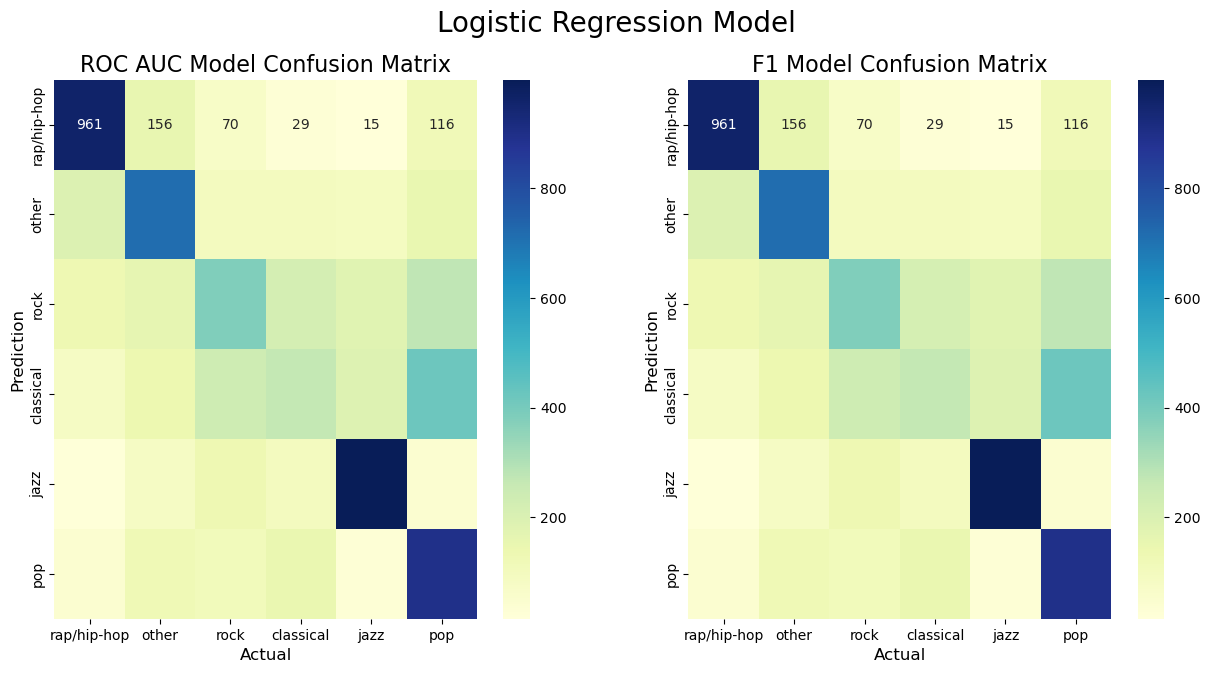

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42) 
 ROC_AUC: 0.8134134351314554
F1 of ROC_AUC model:  0.4961103060961604 

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='newton-cg') 
 F1: 0.496263607003591
ROC_AUC of F1 model:  0.8134125558288073


In [8]:
# Creating LogisticRegression model param grid
logreg_params = {
    'solver':['newton-cg', 'sag', 'saga', 'lbfgs'],
    'class_weight':['balanced']
}

# Initializing LogisticRegression and its GridSearchCV
logreg_model = LogisticRegression(random_state=42, multi_class='auto', n_jobs=-1)
logreg_grid_roc_auc = GridSearchCV(logreg_model, logreg_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
logreg_grid_f1 = GridSearchCV(logreg_model, logreg_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
logreg_grid_roc_auc.fit(X_train, y_train)
logreg_grid_f1.fit(X_train, y_train)
logreg_f1 = cross_val_score(logreg_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
logreg_roc_auc = cross_val_score(logreg_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

logreg_pred = logreg_grid_roc_auc.best_estimator_.predict(X_train)
logreg_f1_pred = logreg_grid_f1.best_estimator_.predict(X_train)
logreg_cm = metrics.confusion_matrix(y_train, logreg_pred)
logreg_f1_cm = metrics.confusion_matrix(y_train, logreg_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(logreg_f1_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Logistic Regression Model', fontsize=20)
plt.show()

print(logreg_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {logreg_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', logreg_f1, '\n')
print(logreg_grid_f1.best_estimator_, '\n', f'F1: {logreg_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', logreg_roc_auc)

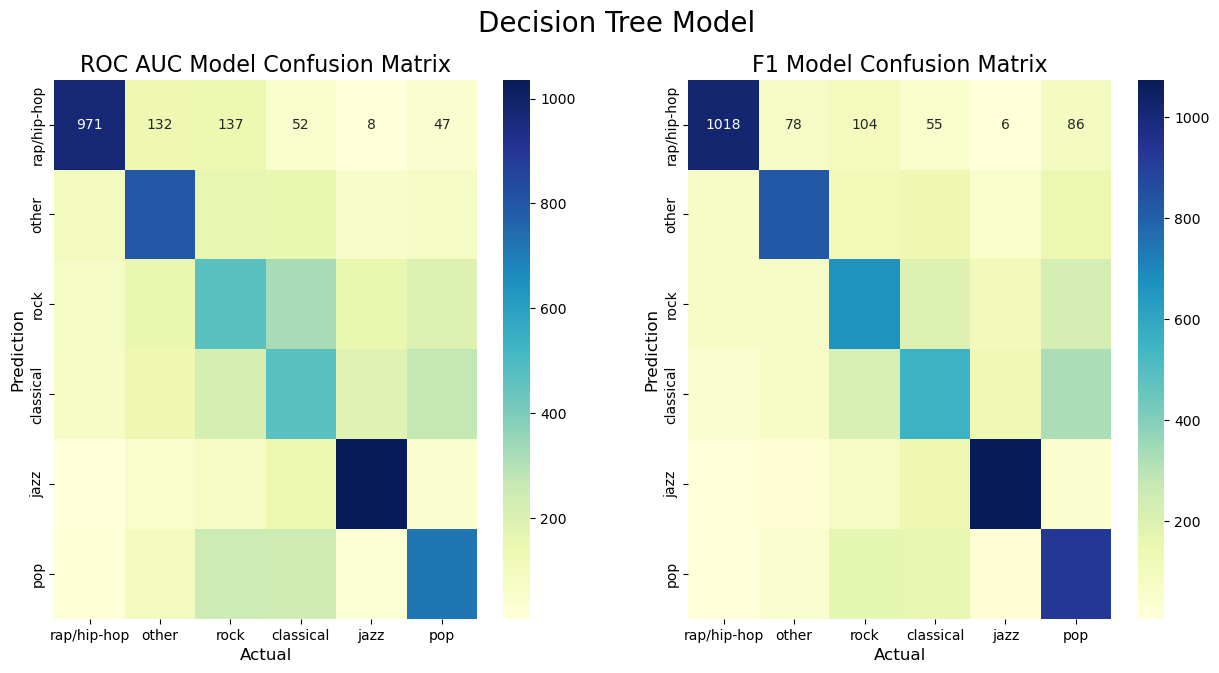

DecisionTreeClassifier(max_depth=7, min_samples_split=6, random_state=42) 
 ROC_AUC: 0.7848547091879969
F1 of ROC_AUC model:  0.48883510505736744 

DecisionTreeClassifier(max_depth=9, min_samples_split=6, random_state=42) 
 F1: 0.4920581980517176
ROC_AUC of F1 model:  0.7697335491769008


In [9]:
# Creating DecisionTree model param grid
tree_params = {
    'max_depth':np.arange(3, 11, 1),
    'min_samples_split':[2,4,6]
}

# Initializing DecisionTree and its GridSearchCV
tree_model = DecisionTreeClassifier(random_state=42)
tree_grid_roc_auc = GridSearchCV(tree_model, tree_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
tree_grid_f1 = GridSearchCV(tree_model, tree_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
tree_grid_roc_auc.fit(X_train, y_train)
tree_grid_f1.fit(X_train, y_train)
tree_f1 = cross_val_score(tree_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
tree_roc_auc = cross_val_score(tree_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

tree_pred = tree_grid_roc_auc.best_estimator_.predict(X_train)
tree_f1_pred = tree_grid_f1.best_estimator_.predict(X_train)
tree_cm = metrics.confusion_matrix(y_train, tree_pred)
tree_f1_cm = metrics.confusion_matrix(y_train, tree_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(tree_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(tree_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Decision Tree Model', fontsize=20)
plt.show()


print(tree_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {tree_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', tree_f1, '\n')
print(tree_grid_f1.best_estimator_, '\n', f'F1: {tree_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', tree_roc_auc)

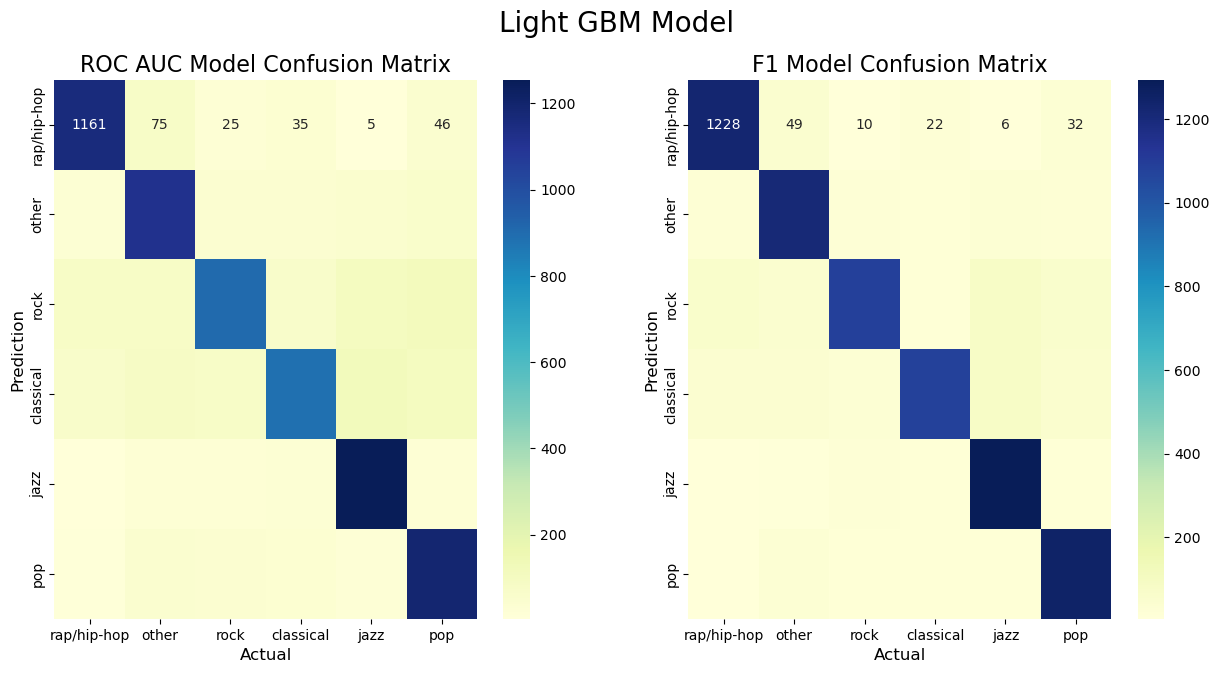

LGBMClassifier(learning_rate=0.01, num_leaves=100, random_state=42,
               verbosity=-1) 
 ROC_AUC: 0.8430090854983877
F1 of ROC_AUC model:  0.552211132334809 

LGBMClassifier(learning_rate=0.01, num_leaves=200, random_state=42,
               verbosity=-1) 
 F1: 0.5528486784693164
ROC_AUC of F1 model:  0.8429362416406931


In [10]:
# Creating LightGBM model param grid
lightgbm_params = {
    'num_leaves':[31, 100, 200],
    'learning_rate':[0.01]
}

# Initializing LightGBM and its GridSearchCV
lightgbm_model = lgb.LGBMClassifier(random_state=42, verbosity=-1)
lightgbm_grid_roc_auc = GridSearchCV(lightgbm_model, lightgbm_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
lightgbm_grid_f1 = GridSearchCV(lightgbm_model, lightgbm_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
lightgbm_grid_roc_auc.fit(X_train, y_train)
lightgbm_grid_f1.fit(X_train, y_train)
lightgbm_f1 = cross_val_score(lightgbm_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
lightgbm_roc_auc = cross_val_score(lightgbm_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

lightgbm_pred = lightgbm_grid_roc_auc.best_estimator_.predict(X_train)
lightgbm_f1_pred = lightgbm_grid_f1.best_estimator_.predict(X_train)
lightgbm_cm = metrics.confusion_matrix(y_train, lightgbm_pred)
lightgbm_f1_cm = metrics.confusion_matrix(y_train, lightgbm_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(lightgbm_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(lightgbm_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Light GBM Model', fontsize=20)
plt.show()

print(lightgbm_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {lightgbm_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', lightgbm_f1, '\n')
print(lightgbm_grid_f1.best_estimator_, '\n', f'F1: {lightgbm_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', lightgbm_roc_auc)

0:	learn: 1.7825995	total: 153ms	remaining: 2m 32s
1000:	learn: 0.9867372	total: 10.6s	remaining: 0us
0:	learn: 1.7827187	total: 16.9ms	remaining: 16.9s
1000:	learn: 0.9908300	total: 9.43s	remaining: 0us
0:	learn: 1.7832833	total: 16.1ms	remaining: 16.1s
1000:	learn: 0.9855568	total: 11.7s	remaining: 0us
0:	learn: 1.7825995	total: 14.8ms	remaining: 29.6s
1000:	learn: 0.9867372	total: 11.2s	remaining: 11.2s
2000:	learn: 0.8367652	total: 21.4s	remaining: 0us
0:	learn: 1.7827187	total: 11.1ms	remaining: 22.2s
1000:	learn: 0.9908300	total: 10.6s	remaining: 10.6s
2000:	learn: 0.8352682	total: 21.4s	remaining: 0us
0:	learn: 1.7832833	total: 11.5ms	remaining: 23s
1000:	learn: 0.9855568	total: 9.96s	remaining: 9.96s
2000:	learn: 0.8339824	total: 20.2s	remaining: 0us
0:	learn: 1.7820866	total: 15.7ms	remaining: 31.4s
1000:	learn: 1.0170596	total: 12.3s	remaining: 12.3s
2000:	learn: 0.8872773	total: 23.6s	remaining: 0us
0:	learn: 1.7825995	total: 16.7ms	remaining: 16.7s
1000:	learn: 0.9867372	to

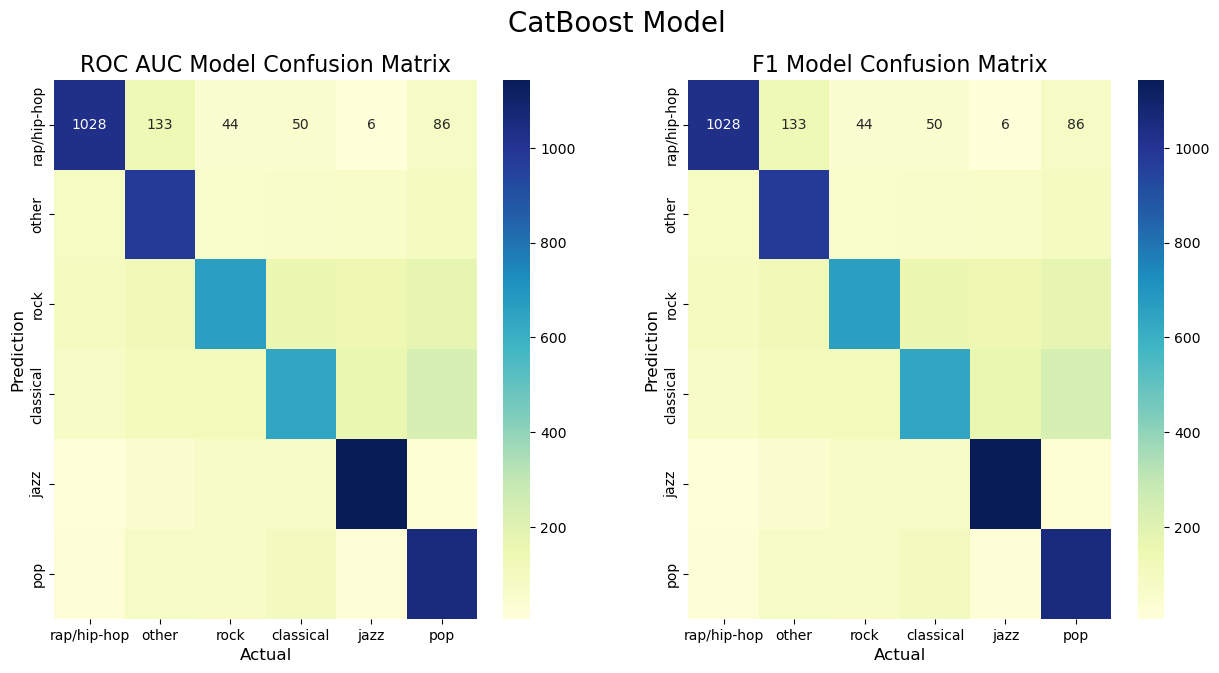

 ROC_AUC: 0.8602969446688212
F1 of ROC_AUC model:  0.5645037939938282 

 F1: 0.5645037939938282
ROC_AUC of F1 model:  0.8602969446688212


In [11]:
# Creating CatBoost model param grid
catboost_params = {
    'iterations':[1001, 2001],
    'learning_rate':[0.01]
}

# Initializing CatBoost and its GridSearchCV
catboost_model = CatBoostClassifier(random_seed=42, verbose=1000)
catboost_grid_roc_auc = GridSearchCV(catboost_model, catboost_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
catboost_grid_f1 = GridSearchCV(catboost_model, catboost_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
catboost_grid_roc_auc.fit(X_train, y_train)
catboost_grid_f1.fit(X_train, y_train)
catboost_f1 = cross_val_score(catboost_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
catboost_roc_auc = cross_val_score(catboost_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

catboost_pred = catboost_grid_roc_auc.best_estimator_.predict(X_train)
catboost_f1_pred = catboost_grid_f1.best_estimator_.predict(X_train)
catboost_cm = metrics.confusion_matrix(y_train, catboost_pred)
catboost_f1_cm = metrics.confusion_matrix(y_train, catboost_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(catboost_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(catboost_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('CatBoost Model', fontsize=20)
plt.show()

print(catboost_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {catboost_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', catboost_f1, '\n')
print(catboost_grid_f1.best_estimator_, '\n', f'F1: {catboost_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', catboost_roc_auc)

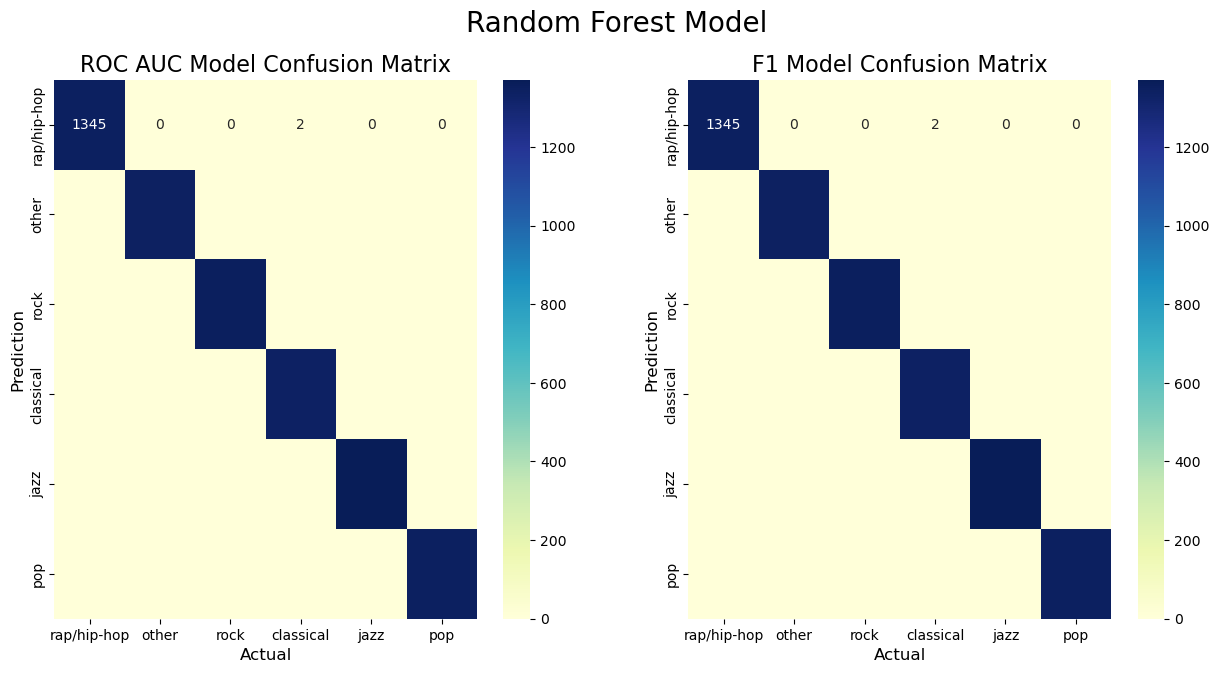

RandomForestClassifier(max_depth=22, n_estimators=1500, random_state=42) 
 ROC_AUC: 0.86568891584527
F1 of ROC_AUC model:  0.5748001862731549 

RandomForestClassifier(max_depth=20, n_estimators=1500, random_state=42) 
 F1: 0.5763375496927452
ROC_AUC of F1 model:  0.8652261027775424


In [12]:
# Creating RandomForest model param grid
forest_params = {
    'n_estimators':[1000, 1500],
    'max_depth':np.arange(18, 27, 2),
}

# Initializing RandomForest and its GridSearchCV
forest_model = RandomForestClassifier(random_state=42)
forest_grid_roc_auc = GridSearchCV(forest_model, forest_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
forest_grid_f1 = GridSearchCV(forest_model, forest_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
forest_grid_roc_auc.fit(X_train, y_train)
forest_grid_f1.fit(X_train, y_train)
forest_f1 = cross_val_score(forest_grid_roc_auc.best_estimator_, X_train, y_train, scoring='f1_weighted', cv=cross_validator).mean()
forest_roc_auc = cross_val_score(forest_grid_f1.best_estimator_, X_train, y_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

forest_pred = forest_grid_roc_auc.best_estimator_.predict(X_train)
forest_f1_pred = forest_grid_f1.best_estimator_.predict(X_train)
forest_cm = metrics.confusion_matrix(y_train, forest_pred)
forest_f1_cm = metrics.confusion_matrix(y_train, forest_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(forest_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(forest_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Random Forest Model', fontsize=20)
plt.show()

print(forest_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {forest_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', forest_f1, '\n')
print(forest_grid_f1.best_estimator_, '\n', f'F1: {forest_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', forest_roc_auc)

## Redundancy

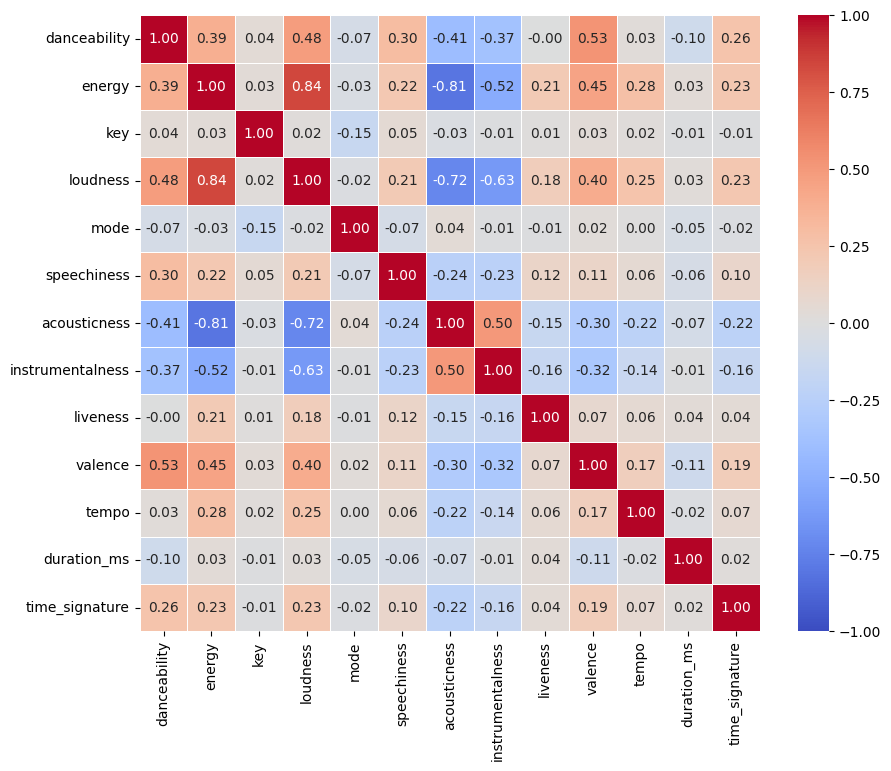

Due to the Attribue Correlation Matrix above created by Michael Velasco, `energy`, `loudness`, and `acousticness` all have a correlation coefficient >= 0.80

The best preforming models will be retrained on the new dataset to prove if the inclusion of these data points helps or harms the models.

In [13]:
data_redundancy = data.drop(['energy', 'loudness', 'acousticness'], axis=1)
redun_train, redun_test = train_test_split(data_redundancy, test_size=0.1, random_state=42)
print(redun_train.shape)
print(redun_test.shape)

reX_train = redun_train.drop(['genre'], axis=1)
rey_train = redun_train['genre']
reX_test = redun_test.drop(['genre'], axis=1)
rey_test = redun_test['genre']

print(reX_train.shape, rey_train.shape)
print(reX_test.shape, rey_test.shape)

(8100, 11)
(900, 11)
(8100, 10) (8100,)
(900, 10) (900,)


0:	learn: 1.7836548	total: 21.7ms	remaining: 21.7s
1000:	learn: 1.0732818	total: 8.13s	remaining: 0us
0:	learn: 1.7837211	total: 9.99ms	remaining: 9.99s
1000:	learn: 1.0848421	total: 7.97s	remaining: 0us
0:	learn: 1.7834830	total: 10.8ms	remaining: 10.8s
1000:	learn: 1.0820406	total: 8.72s	remaining: 0us
0:	learn: 1.7836548	total: 10.3ms	remaining: 20.7s
1000:	learn: 1.0732818	total: 8.35s	remaining: 8.34s
2000:	learn: 0.9271157	total: 15.8s	remaining: 0us
0:	learn: 1.7837211	total: 19.1ms	remaining: 38.1s
1000:	learn: 1.0848421	total: 7.45s	remaining: 7.45s
2000:	learn: 0.9390023	total: 14.9s	remaining: 0us
0:	learn: 1.7834830	total: 8.63ms	remaining: 17.3s
1000:	learn: 1.0820406	total: 7.92s	remaining: 7.92s
2000:	learn: 0.9349059	total: 15.1s	remaining: 0us
0:	learn: 1.7835011	total: 21.6ms	remaining: 43.1s
1000:	learn: 1.1088551	total: 9.03s	remaining: 9.02s
2000:	learn: 0.9854119	total: 18.6s	remaining: 0us
0:	learn: 1.7836548	total: 10.1ms	remaining: 10.1s
1000:	learn: 1.0732818	

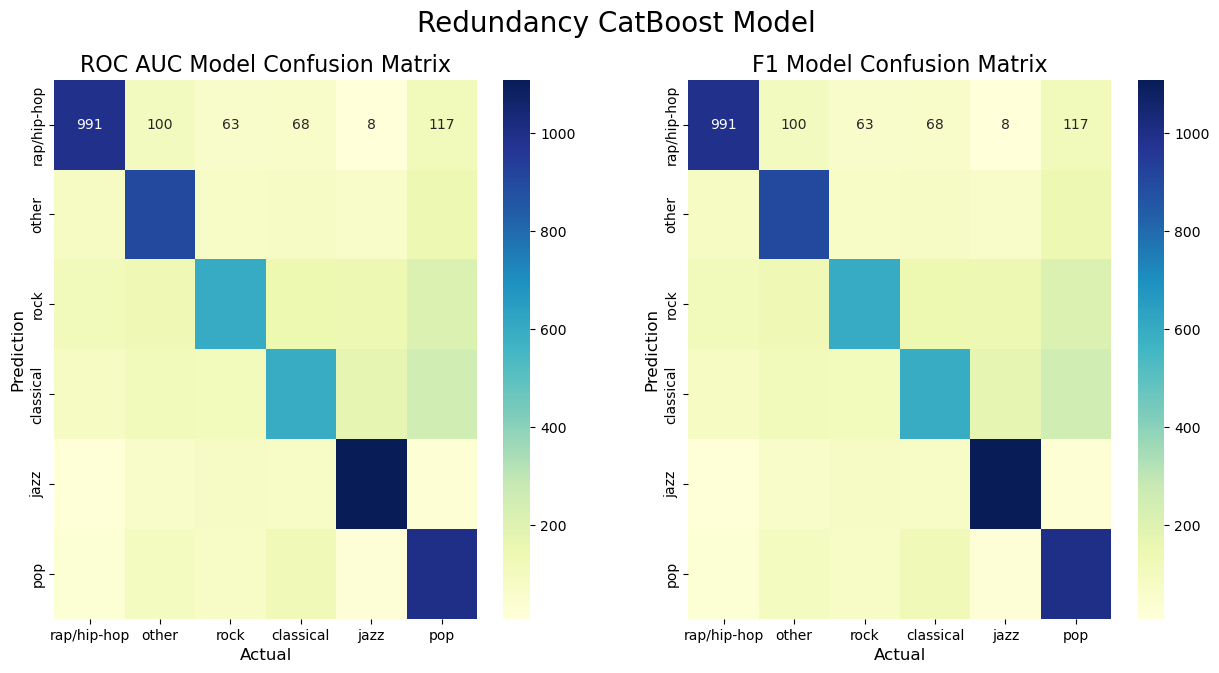

 ROC_AUC: 0.8318707090754911
F1 of ROC_AUC model:  0.5289262913008487 

 F1: 0.5289262913008487
ROC_AUC of F1 model:  0.8318707090754911


In [14]:
# Initializing CatBoost and its GridSearchCV
recatboost_model = CatBoostClassifier(random_seed=42, verbose=1000)
recatboost_grid_roc_auc = GridSearchCV(recatboost_model, catboost_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
recatboost_grid_f1 = GridSearchCV(recatboost_model, catboost_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
recatboost_grid_roc_auc.fit(reX_train, rey_train)
recatboost_grid_f1.fit(reX_train, rey_train)
recatboost_f1 = cross_val_score(recatboost_grid_roc_auc.best_estimator_, reX_train, rey_train, scoring='f1_weighted', cv=cross_validator).mean()
recatboost_roc_auc = cross_val_score(recatboost_grid_f1.best_estimator_, reX_train, rey_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

recatboost_pred = recatboost_grid_roc_auc.best_estimator_.predict(reX_train)
recatboost_f1_pred = recatboost_grid_f1.best_estimator_.predict(reX_train)
recatboost_cm = metrics.confusion_matrix(rey_train, recatboost_pred)
recatboost_f1_cm = metrics.confusion_matrix(rey_train, recatboost_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(recatboost_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=rey_train.value_counts().index, yticklabels=rey_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(recatboost_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=rey_train.value_counts().index, yticklabels=rey_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Redundancy CatBoost Model', fontsize=20)
plt.show()

print(recatboost_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {recatboost_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', recatboost_f1, '\n')
print(recatboost_grid_f1.best_estimator_, '\n', f'F1: {recatboost_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', recatboost_roc_auc)

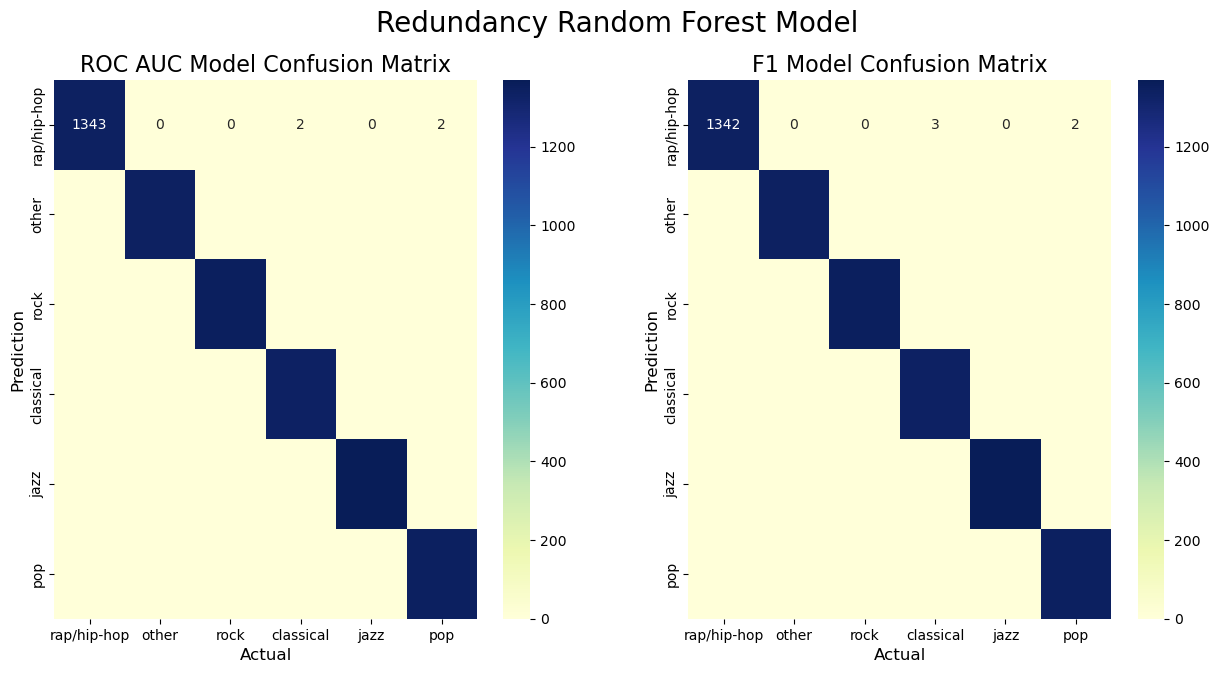

RandomForestClassifier(max_depth=18, n_estimators=1500, random_state=42) 
 ROC_AUC: 0.8332810308550312
F1 of ROC_AUC model:  0.5346303521768693 

RandomForestClassifier(max_depth=18, n_estimators=1000, random_state=42) 
 F1: 0.5364280521728791
ROC_AUC of F1 model:  0.8331529618997306


In [15]:
# Initializing RandomForest and its GridSearchCV
reforest_model = RandomForestClassifier(random_state=42)
reforest_grid_roc_auc = GridSearchCV(reforest_model, forest_params, scoring='roc_auc_ovo_weighted', cv=cross_validator)
reforest_grid_f1 = GridSearchCV(reforest_model, forest_params, scoring='f1_weighted', cv=cross_validator)

# Training Grid
reforest_grid_roc_auc.fit(reX_train, rey_train)
reforest_grid_f1.fit(reX_train, rey_train)
reforest_f1 = cross_val_score(reforest_grid_roc_auc.best_estimator_, reX_train, rey_train, scoring='f1_weighted', cv=cross_validator).mean()
reforest_roc_auc = cross_val_score(reforest_grid_f1.best_estimator_, reX_train, rey_train, scoring='roc_auc_ovo_weighted', cv=cross_validator).mean()

reforest_pred = reforest_grid_roc_auc.best_estimator_.predict(reX_train)
reforest_f1_pred = reforest_grid_f1.best_estimator_.predict(reX_train)
reforest_cm = metrics.confusion_matrix(rey_train, reforest_pred)
reforest_f1_cm = metrics.confusion_matrix(rey_train, reforest_f1_pred)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(reforest_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=rey_train.value_counts().index, yticklabels=rey_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('ROC AUC Model Confusion Matrix',fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(reforest_f1_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=rey_train.value_counts().index, yticklabels=rey_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('F1 Model Confusion Matrix',fontsize=16)
plt.suptitle('Redundancy Random Forest Model', fontsize=20)
plt.show()

print(reforest_grid_roc_auc.best_estimator_, '\n', f'ROC_AUC: {reforest_grid_roc_auc.best_score_}')
print('F1 of ROC_AUC model: ', reforest_f1, '\n')
print(reforest_grid_f1.best_estimator_, '\n', f'F1: {reforest_grid_f1.best_score_}')
print('ROC_AUC of F1 model: ', reforest_roc_auc)

## Test

RandomForestClassifier(max_depth=22, n_estimators=1500, random_state=42) 

Test ROC_AUC: 0.8818240063406922
Test F1 :  0.6044101972722081


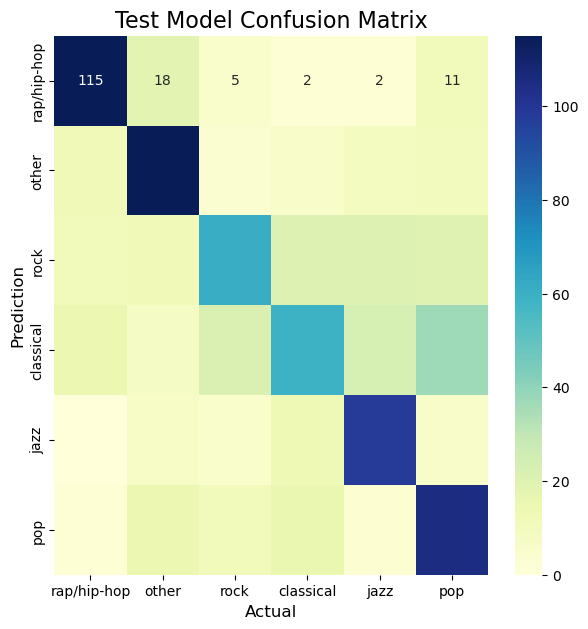

In [18]:
# Choosing test model
test_model = forest_grid_f1.best_estimator_

# Predicting test dataset
test_predict = test_model.predict(X_test)
test_proba = test_model.predict_proba(X_test)
test_roc_auc = metrics.roc_auc_score(y_test, test_proba, average='weighted', multi_class='ovo')
test_f1 = metrics.f1_score(y_test, test_predict, average='weighted')
test_cm = metrics.confusion_matrix(y_test, test_predict)

plt.figure(figsize=(7,7))
sns.heatmap(test_cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=y_train.value_counts().index, yticklabels=y_train.value_counts().index)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Test Model Confusion Matrix',fontsize=16)

print(forest_grid_roc_auc.best_estimator_, '\n')
print('Test ROC_AUC:', test_roc_auc)
print('Test F1 : ', test_f1)
plt.show()